In [1]:
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from matplotlib import pyplot as plt

sns.set()

In [2]:
# project files
from rp_model.files import set_files_directory

set_files_directory("./files")

from rp_model.calc import (
    FitOptions, compute_rp, make_precomputed_columns, make_initial_guess
)
from rp_model.utils import (
    pack, unpack, table, DataStore
)

In [3]:
# stuff for display

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 120)

In [4]:
data = pd.read_pickle(FitOptions.data_file)
data.describe()
data.head()

,Level,RP,MS lvl,ModelRP,Difference,Freq1,FreqL,Inv,Berry1,BerryL,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,BerryD,IngD,Dupes,Amnt,Ing2P,Help skill bonus,RP Multiplier
count,7771.000000,7771.000000,7771.000000,7771.000000,7771.000000,7771.000000,7771.000000,7771.000000,7771.000000,7771.000000,7771.000000,7771.000000,7771.000000,7771.000000,7771.000000,7771.00000,7771.000000,7771.000000,7771.000000,7771.000000,7771.0,7771.000000,7771.000000,7771.000000,7771.000000
mean,11.713422,663.504182,1.581135,663.510616,0.006434,3864.869386,3702.560196,12.517694,28.021876,38.874276,108.521554,1.052698,0.987675,0.994451,0.997529,1.00960,0.207487,36.214361,56.775576,148.531141,1.0,0.108352,4.518852,0.985299,1.031560
std,7.755388,442.393993,1.059953,442.407173,0.577314,976.068160,1042.780251,3.542903,2.596460,8.685571,16.133481,0.320600,0.058436,0.044974,0.118567,0.11866,0.045806,40.553191,28.692011,62.733171,0.0,0.612689,24.710514,0.040890,0.073808
min,1.000000,245.000000,1.000000,245.000000,-15.000000,2200.000000,1489.118400,7.000000,24.000000,24.000000,90.000000,0.520000,0.890000,0.920000,0.800000,0.80000,0.130000,5.940000,25.000000,90.000000,1.0,0.000000,0.000000,0.790000,1.000000
25%,6.000000,364.000000,1.000000,365.000000,0.000000,3000.000000,2836.200000,10.000000,26.000000,33.000000,98.000000,0.820000,1.000000,1.000000,1.000000,1.00000,0.180000,14.120000,36.000000,101.000000,1.0,0.000000,0.000000,1.000000,1.000000
50%,10.000000,509.000000,1.000000,509.000000,0.000000,3800.000000,3678.400000,12.000000,28.000000,37.000000,103.000000,0.970000,1.000000,1.000000,1.000000,1.00000,0.200000,20.750000,47.000000,121.000000,1.0,0.000000,0.000000,1.000000,1.000000
75%,15.000000,784.000000,2.000000,784.000000,0.000000,4500.000000,4382.780000,15.000000,30.000000,43.000000,115.000000,1.260000,1.000000,1.000000,1.000000,1.00000,0.230000,48.080000,68.000000,202.000000,1.0,0.000000,0.000000,1.000000,1.000000
max,45.000000,3493.000000,6.000000,3495.000000,5.000000,6300.000000,6916.140000,24.000000,35.000000,83.000000,151.000000,2.410000,1.120000,1.080000,1.200000,1.20000,0.420000,414.120000,243.000000,511.000000,1.0,8.000000,342.000000,1.000000,1.440000


,Pokemon,Level,RP,Nature,MS lvl,Source,ModelRP,Difference,Nature2,ID,NatureP,NatureN,Freq1,FreqL,Type,Class,MSkill,Inv,Berry1,BerryL,Ing1,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,RPneutral,IDNeutral,BerryD,IngD,Dupes,DupeMatch,Sub Skill 1,Sub Skill 2,Ingredient 2,Amnt,Ing2P,Help skill bonus,RP Multiplier
0,Arbok,9.0,574.0,Naughty,1.0,Rate My Mon,574.0,0.0,Naughty,ArbokNaughty91,Speed of Help,Main Skill Chance,3700.0,3276.72,Poison,Berries,Charge Energy S,14.0,32.0,40,Bean Sausage,103.0,1.09,0.9,1.00,1.0,0.8,0.26,22.75,538.35,ArbokNeutral91,80.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
1,Arbok,8.0,531.0,Hardy,1.0,Questions help guides,531.0,0.0,Neutral,ArbokNeutral81,-,-,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.0,1.00,1.0,1.0,0.26,22.75,531.00,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
2,Arbok,8.0,538.0,Quiet,1.0,Questions help guides,538.0,0.0,Quiet,ArbokQuiet81,Ingredient Finding,Exp Gains,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.0,1.00,1.2,1.0,0.26,22.75,530.61,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
3,Arbok,9.0,582.0,Relaxed,1.0,,582.0,0.0,Relaxed,ArbokRelaxed91,Energy Recovery,EXP Gains,3700.0,3640.80,Poison,Berries,Charge Energy S,14.0,32.0,40,Bean Sausage,103.0,0.98,1.0,1.08,1.0,1.0,0.26,22.75,538.89,ArbokNeutral91,80.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
4,Arbok,9.0,489.0,Timid,1.0,,489.0,0.0,Timid,ArbokTimid91,EXP Gains,Speed of Help,3700.0,4004.88,Poison,Berries,Charge Energy S,14.0,32.0,40,Bean Sausage,103.0,0.89,1.1,1.00,1.0,1.0,0.26,22.75,538.45,ArbokNeutral91,80.0,103.0,1,True,,,,0.0,0.0,1.0,1.0


In [5]:
# Make an initial guess
# Pack the dictionary into a 1-D vector.
# Also store information on how to unpack that vector

x0, unpack_info = pack(*make_initial_guess())
computed = make_precomputed_columns(data)

In [6]:
# We compute the RP model in rp_model.py
# Here we create closure to glue the pieces together.

def RP(x):
    return compute_rp(x, data, computed, unpack_info)


# for the error analysis page,
# we'll compute the residual with exact rounding.

def residual(x):
    return data["RP"] - np.round(RP(x))


In [7]:
store = (DataStore()
         .with_dependency_on(data, x0)
         .try_read_and_validate(FitOptions.result_file)
         )

opt = store.data()
sol = unpack(opt.x, unpack_info)

opt

    message: `ftol` termination condition is satisfied.
    success: True
     status: 2
          x: [ 5.625e-01  5.436e-01 ...  3.747e-01  3.691e-01]
       cost: 1283.8894778888819
       grad: [ 1.364e-05  3.493e-06 ...  0.000e+00  0.000e+00]
 optimality: 0.0070385140425059944
       nfev: 21
       njev: 10

In [8]:
# What are the worst points?

df = data[["Pokemon", "ID", "Level", "Class", "Inv", "MS lvl", "NatureP", "NatureN", "Sub Skill 1", "Sub Skill 2",
           "RP"]].copy()

df["fit"] = np.round(RP(opt.x))
df["error"] = residual(opt.x)
df["error2"] = df["error"] ** 2

df = df.sort_values("error2", ascending=False)
df.head(100)

,Pokemon,ID,Level,Class,Inv,MS lvl,NatureP,NatureN,Sub Skill 1,Sub Skill 2,RP,fit,error,error2
1837,Glaceon,GlaceonNeutral276Skill Level Up MHelping Speed M,27.0,Skills,12.0,6.0,-,-,Skill Level Up M,Helping Speed M,2485.0,2469.0,16.0,256.0
3076,Raichu,RaichuNaughty313Helping Speed SInventory Up S,31.0,Berries,21.0,3.0,Speed of Help,Main Skill Chance,Helping Speed S,Inventory Up S,1663.0,1655.0,8.0,64.0
3662,Togekiss,TogekissGentle103Skill Trigger M,10.0,Skills,16.0,3.0,Main Skill Chance,Energy Recovery,Skill Trigger M,,1282.0,1274.0,8.0,64.0
3589,Sylveon,SylveonRelaxed102Helping Bonus,10.0,Skills,15.0,2.0,Energy Recovery,EXP Gains,Helping Bonus,,1023.0,1015.0,8.0,64.0
551,Charizard,CharizardNeutral273Berry Finding SHelping Speed M,27.0,Ingredients,19.0,3.0,-,-,Berry Finding S,Helping Speed M,1528.0,1520.0,8.0,64.0
556,Charizard,CharizardRash273Helping BonusHelping Speed M,27.0,Ingredients,19.0,3.0,Ingredient Finding,Main Skill Chance,Helping Bonus,Helping Speed M,1440.0,1432.0,8.0,64.0
3849,Typhlosion,TyphlosionCareful273Berry Finding SHelping Spe...,27.0,Berries,23.0,3.0,Main Skill Chance,Ingredient Finding,Berry Finding S,Helping Speed M,1761.0,1754.0,7.0,49.0
552,Charizard,CharizardNeutral273Inventory Up MHelping Speed M,27.0,Ingredients,19.0,3.0,-,-,Inventory Up M,Helping Speed M,1299.0,1292.0,7.0,49.0
544,Charizard,CharizardMild276Helping Speed MSkill Level Up M,27.0,Ingredients,19.0,6.0,Ingredient Finding,Energy Recovery,Helping Speed M,Skill Level Up M,1514.0,1507.0,7.0,49.0
545,Charizard,CharizardMild276Skill Level Up MHelping Speed M,27.0,Ingredients,19.0,6.0,Ingredient Finding,Energy Recovery,Skill Level Up M,Helping Speed M,1514.0,1507.0,7.0,49.0


In [9]:
# What are the worst points, level 1-9, Main Skill 1 ?
level_1_9 = df[(df["Level"] < 10)]
level_1_9_error = level_1_9[level_1_9["error2"] > 0.5]

level_1_9.describe()
level_1_9_error.describe()
level_1_9_error.head(100)

,Level,Inv,MS lvl,RP,fit,error,error2
count,3365.000000,3365.000000,3365.000000,3365.000000,3365.000000,3365.000000,3365.000000
mean,5.207429,10.520357,1.039822,375.873700,375.876077,-0.002377,0.049331
std,2.290004,2.299631,0.215802,85.105707,85.102329,0.222127,0.216591
min,1.000000,7.000000,1.000000,245.000000,245.000000,-1.000000,0.000000
25%,3.000000,9.000000,1.000000,320.000000,320.000000,0.000000,0.000000
50%,5.000000,10.000000,1.000000,354.000000,354.000000,0.000000,0.000000
75%,7.000000,12.000000,1.000000,407.000000,407.000000,0.000000,0.000000
max,9.000000,21.000000,3.000000,1089.000000,1088.000000,1.000000,1.000000


,Level,Inv,MS lvl,RP,fit,error,error2
count,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.0
mean,5.006024,11.204819,1.180723,422.512048,422.560241,-0.048193,1.0
std,2.458127,2.688963,0.444347,147.593616,147.538570,1.001860,0.0
min,1.000000,7.000000,1.000000,262.000000,263.000000,-1.000000,1.0
25%,3.000000,10.000000,1.000000,332.250000,331.250000,-1.000000,1.0
50%,5.000000,10.000000,1.000000,375.500000,375.000000,-1.000000,1.0
75%,7.000000,12.000000,1.000000,447.750000,448.250000,1.000000,1.0
max,9.000000,21.000000,3.000000,1089.000000,1088.000000,1.000000,1.0


,Pokemon,ID,Level,Class,Inv,MS lvl,NatureP,NatureN,Sub Skill 1,Sub Skill 2,RP,fit,error,error2
3425,Pichu,PichuCareful51,5.0,Berries,10.0,1.0,Main Skill Chance,Ingredient Finding,,,314.0,313.0,1.0,1.0
3420,Togepi,TogepiNaive41,4.0,Skills,8.0,1.0,EXP Gains,Main Skill Chance,,,288.0,287.0,1.0,1.0
981,Dugtrio,DugtrioQuiet91,9.0,Ingredients,16.0,1.0,Ingredient Finding,Exp Gains,,,576.0,577.0,-1.0,1.0
1023,Eevee,EeveeCareful91,9.0,Skills,12.0,1.0,Main Skill Chance,Ingredient Finding,,,511.0,510.0,1.0,1.0
1053,Eevee,EeveeJolly81,8.0,Skills,12.0,1.0,EXP Gains,Ingredient Finding,,,459.0,458.0,1.0,1.0
1309,Gastly,GastlyRash51,5.0,Ingredients,10.0,1.0,Ingredient Finding,Main Skill Chance,,,357.0,358.0,-1.0,1.0
1308,Gastly,GastlyRash41,4.0,Ingredients,10.0,1.0,Ingredient Finding,Main Skill Chance,,,352.0,353.0,-1.0,1.0
3201,Totodile,TotodileHasty91,9.0,Berries,11.0,1.0,EXP Gains,Energy Recovery,,,395.0,396.0,-1.0,1.0
1282,Gastly,GastlyNaive61,6.0,Ingredients,10.0,1.0,EXP Gains,Main Skill Chance,,,330.0,331.0,-1.0,1.0
1281,Gastly,GastlyNaive51,5.0,Ingredients,10.0,1.0,EXP Gains,Main Skill Chance,,,325.0,326.0,-1.0,1.0


intercept,0.0089747
intercept_stderr,0.0118389
pvalue,0.317148
rvalue,-0.0113492
slope,-0.000843092
stderr,0.000842753


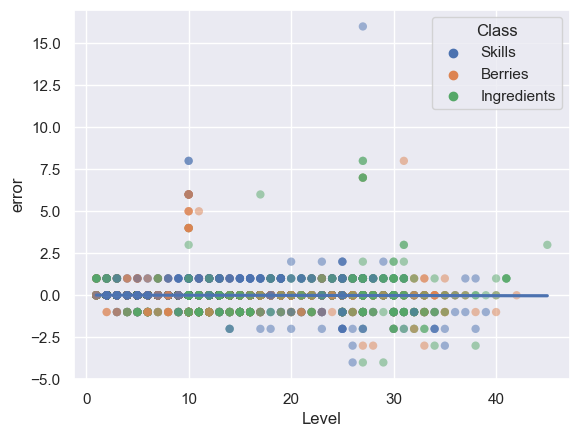

In [10]:
# Plot error vs level

err = df[["Level", "error", "Class"]]
palette = sns.color_palette(n_colors=3)

_ = sns.scatterplot(data=err, x="Level", y="error", hue="Class", alpha=0.5, linewidth=0, palette=palette)
_ = sns.regplot(data=err, x="Level", y="error", scatter=False)

# What is the slope?
linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])
table(linearfit)

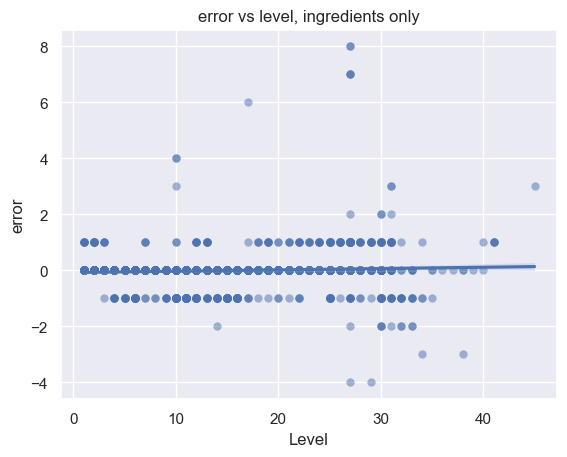

In [11]:
err2 = err[err["Class"] == "Ingredients"]
p = sns.scatterplot(data=err2, x="Level", y="error", alpha=0.5, linewidth=0, color=palette[0])
_ = sns.regplot(data=err2, x="Level", y="error", scatter=False)
_ = p.set(title='error vs level, ingredients only')


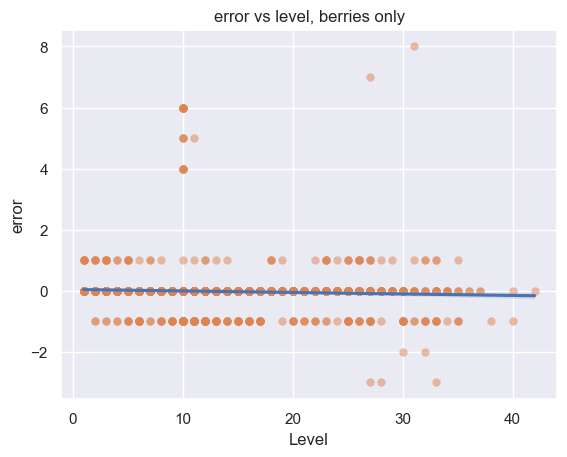

In [12]:
err2 = err[err["Class"] == "Berries"]
p = sns.scatterplot(data=err2, x="Level", y="error", alpha=0.5, linewidth=0, color=palette[1])
_ = sns.regplot(data=err2, x="Level", y="error", scatter=False)
_ = p.set(title='error vs level, berries only')

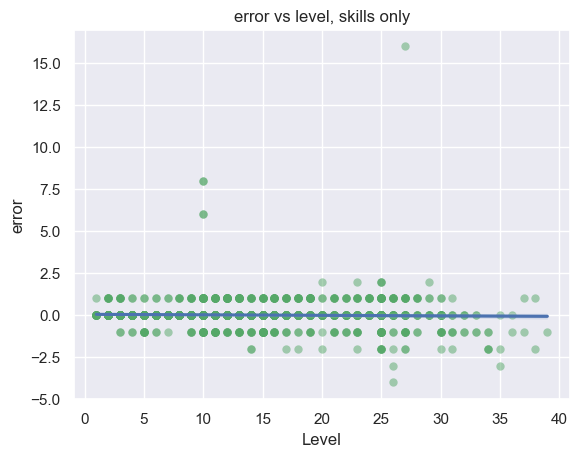

In [13]:
err2 = err[err["Class"] == "Skills"]

p = sns.scatterplot(data=err2, x="Level", y="error", alpha=0.5, linewidth=0, color=palette[2])
_ = sns.regplot(data=err2, x="Level", y="error", scatter=False)
_ = p.set(title='error vs level, skills only')


intercept,-0.0112263
intercept_stderr,0.00796168
pvalue,0.767999
rvalue,-0.00405528
slope,-0.000238461
stderr,0.00080832


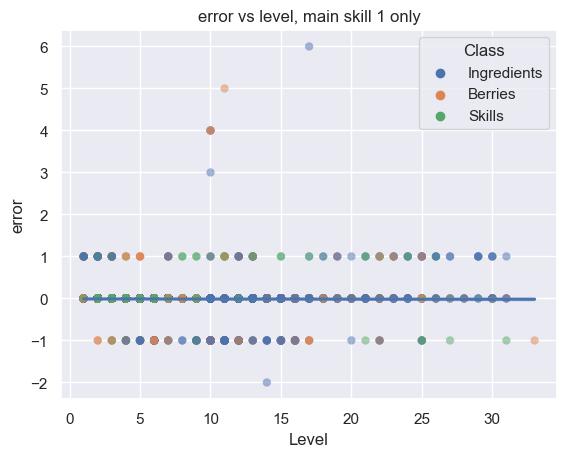

In [14]:
# Plot error vs level - focus on main skill 1

err = df[["Level", "error", "Class"]].loc[df["MS lvl"] == 1]

p = sns.scatterplot(data=err, x="Level", y="error", hue="Class", alpha=0.5, linewidth=0)
_ = sns.regplot(data=err, x="Level", y="error", scatter=False)

_ = p.set(title='error vs level, main skill 1 only')

# What is the slope ?
linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])
table(linearfit)

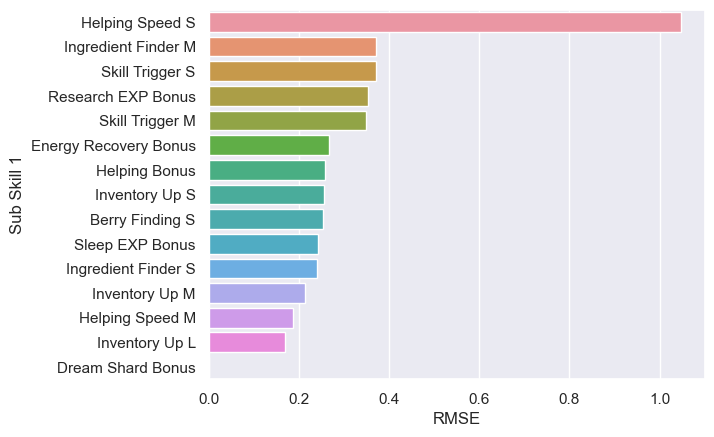

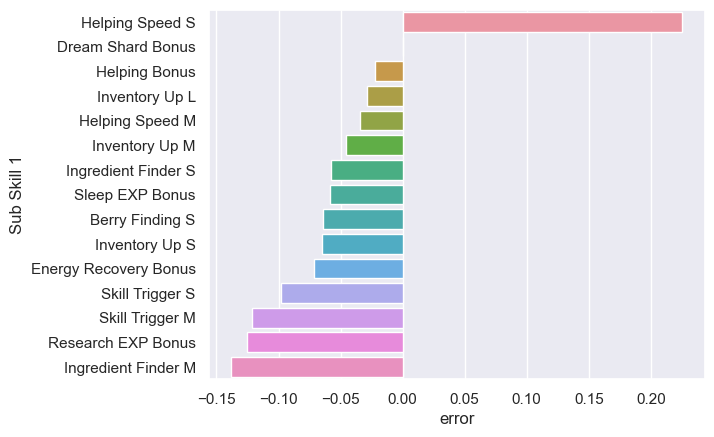

In [15]:
# Let's see what happens at level 10 and main skill 1

subskill_err = (df[["Level", "Sub Skill 1", "error", "error2"]].loc[(df["Level"] == 10) & (df["MS lvl"] == 1)]
                .groupby("Sub Skill 1")
                .mean()
                .sort_values("error2", ascending=False)
                .reset_index())

subskill_err["RMSE"] = np.sqrt(subskill_err["error2"])

_ = plt.figure()
_ = sns.barplot(data=subskill_err, y="Sub Skill 1", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=subskill_err.sort_values("error", ascending=False), y="Sub Skill 1", x="error")


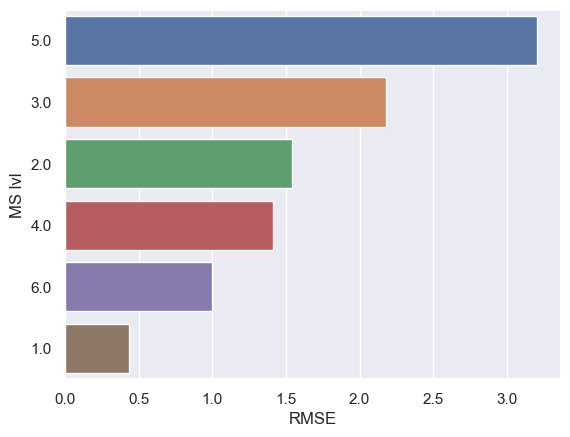

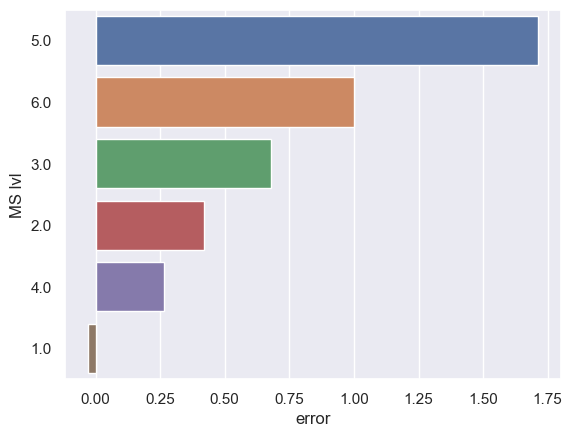

In [16]:
mslvl_err = (df[["Level", "MS lvl", "error", "error2"]][df["Level"] == 10]
             .groupby("MS lvl")
             .mean()
             .sort_values("error2", ascending=False)
             .reset_index())

mslvl_err["RMSE"] = np.sqrt(mslvl_err["error2"])
mslvl_err["MS lvl"] = mslvl_err["MS lvl"].astype(str)

_ = plt.figure()
_ = sns.barplot(data=mslvl_err, y="MS lvl", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=mslvl_err.sort_values("error", ascending=False), y="MS lvl", x="error")


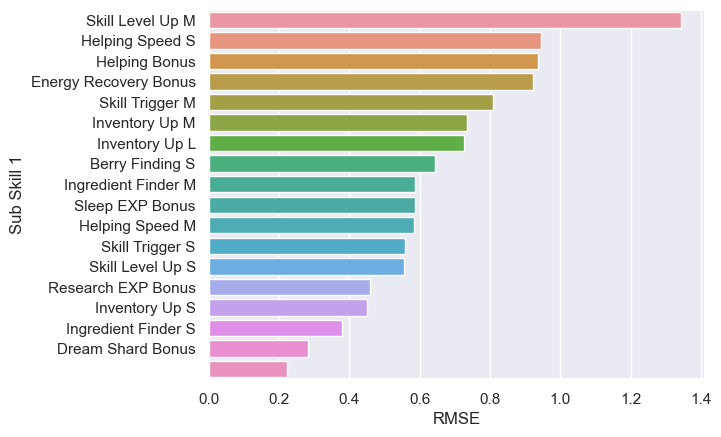

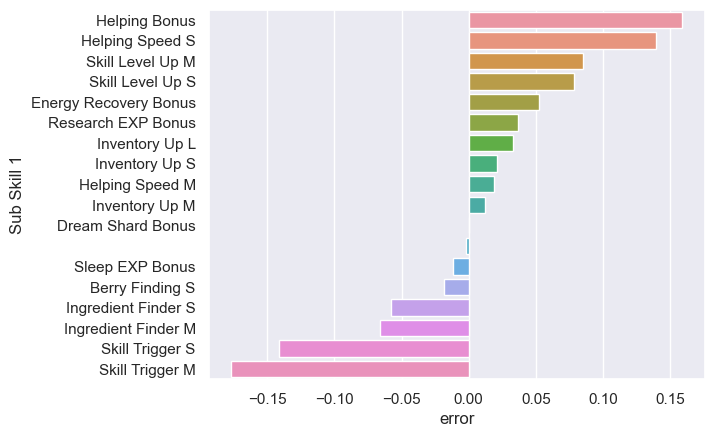

In [17]:
# Do we have more error in some skills ?

errorbyskill1 = (df[["Sub Skill 1", "error", "error2"]]
                 .groupby("Sub Skill 1")
                 .mean()
                 .sort_values("error2", ascending=False)
                 #.rename(columns={"error":"avg abs error"})
                 .reset_index())

errorbyskill1["RMSE"] = np.sqrt(errorbyskill1["error2"])

_ = plt.figure()
_ = sns.barplot(data=errorbyskill1, y="Sub Skill 1", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=errorbyskill1.sort_values("error", ascending=False), y="Sub Skill 1", x="error")

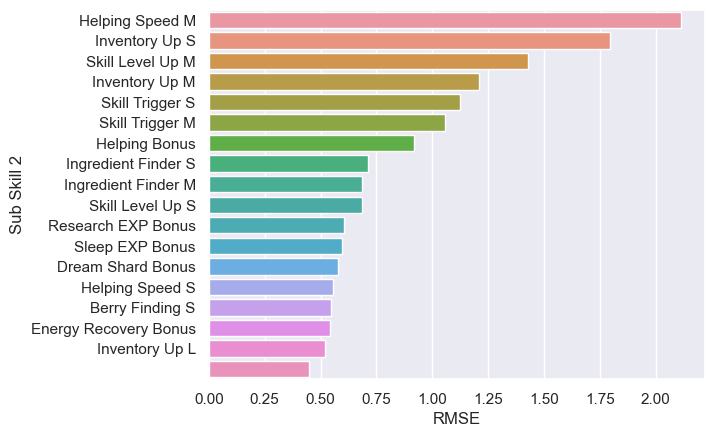

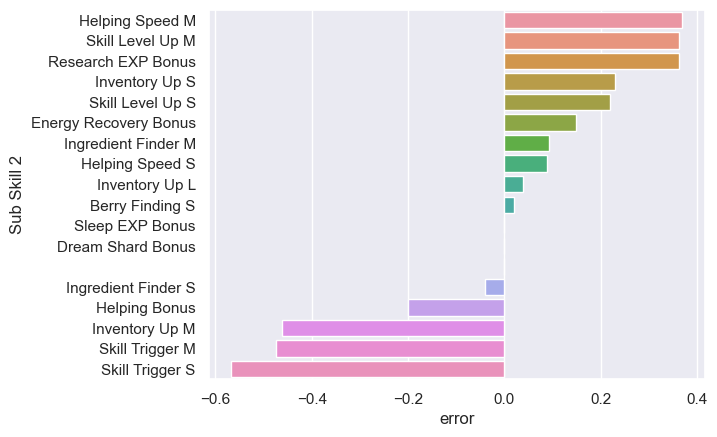

In [18]:
errorbyskill2 = (df[["Sub Skill 2", "error", "error2"]]
                 .groupby("Sub Skill 2")
                 .mean()
                 .sort_values("error2", ascending=False)
                 #.rename(columns={"error":"avg abs error"})
                 .reset_index())

errorbyskill2["RMSE"] = np.sqrt(errorbyskill2["error2"])

_ = plt.figure()
_ = sns.barplot(data=errorbyskill2, y="Sub Skill 2", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=errorbyskill2.sort_values("error", ascending=False), y="Sub Skill 2", x="error")